# A Simple Graph Neural Network from Scratch
# Goals : 
1. An illustration of GCN for graph classification
2. A toy application to Letter classification
3. A lecture on Structured Machine Learning

# Author: Romain Raveaux (romain.raveaux@univ-tours.fr)
# Acknowledgement 
1. Datasets and functions to read data are taken from http://gmprdia.univ-lr.fr/


# The lecture
The content of the is notebook is based on the following lectures : 
Supervised Machine Learning for structured input/output: Polytech, Tours

*   1\. Introduction to supervised Machine Learning: A probabilistic introduction [PDF](http://romain.raveaux.free.fr/document/courssupervisedmachinelearningRaveaux.pdf)

*   2\. Connecting local models : The case of chains [PDF slides](http://romain.raveaux.free.fr/document/Connecting%20local%20models%20the%20case%20of%20chains%20.pdf)

*   3\. Connecting local models : Beyond chains and trees.[PDF slides](http://romain.raveaux.free.fr/document/Structured%20Output%20Learning.pdf)

*   4\. Machine Learning and Graphs : Introduction and problems [PDF slides](http://romain.raveaux.free.fr/document/cours%20IA%20DI5%20graphs%20introV2.pdf)

*   5\. **Graph Neural Networks.** [PDF slides](http://romain.raveaux.free.fr/document/graph%20neural%20networks%20romain%20raveaux.pdf)

*   6\. Graph Kernels. [PDF slides](http://romain.raveaux.free.fr/document/graph%20kernel%20romain%20raveaux.pdf)


## Install requirements

*   [Network](https://networkx.github.io/)
*   [Pytorch](https://pytorch.org/)
* scipy

If needed uncomment the following commands : 

In [335]:
#!pip install networkx
#!pip install torch
#!pip install scipy
#!pip install matplotlib

##Download Data

###Letter Database

Graphs that represent distorted letter drawings. They consider the 15 capital letters of the Roman alphabet that consist of straight lines only (A, E, F, H, I, K, L, M, N, T, V, W, X, Y, Z). Each node is labeled with a two-dimensional attribute giving its position relative to a reference coordinate system. Edges are unlabeled. The graph database consists of a training set, a validation set, and a test set of size 750 each. Also, three levels of distortions are provided.

This dataset is part of [IAM Graph Database Repository](http://www.fki.inf.unibe.ch/databases/iam-graph-database) and it is also linked in the [IAPR TC15 resources](https://iapr-tc15.greyc.fr/links.html).

It can be considered as a **TOY EXAMPLE** for graph classification.

> Riesen, K. and Bunke, H.: [IAM Graph Database Repository for Graph Based Pattern Recognition and Machine Learning.](https://link.springer.com/chapter/10.1007/978-3-540-89689-0_33) In: da Vitora Lobo, N. et al. (Eds.), SSPR&SPR 2008, LNCS, vol. 5342, pp. 287-297, 2008.

If you have a Linux system or if you use Google Colab you can use the following commands (uncomment them):

In [336]:
#!wget https://iapr-tc15.greyc.fr/IAM/Letter.zip
#!unzip Letter.zip

## Prepare data reader

IAM graphs are provided as a GXL file:


```
<gxl>
  <graph id="GRAPH_ID" edgeids="false" edgemode="undirected">
    <node id="_0">
      <attr name="x">
        <float>0.812867</float>
      </attr>
      <attr name="y">
        <float>0.630453</float>
      </attr>
    </node>
    ...
    <node id="_N">
      ...
    </node>
    <edge from="_0" to="_1"/>
    ...
    <edge from="_M" to="_N"/>
  </graph>
</gxl>
```

In [337]:
import numpy as np
import xml.etree.ElementTree as ET
import networkx as nx
import torch


def read_letters(file):
  """Parse GXL file and returns a networkx graph
  """
  
  tree_gxl = ET.parse(file)
  root_gxl = tree_gxl.getroot()
  node_label = {}
  node_id = []
  
  # Parse nodes
  for i, node in enumerate(root_gxl.iter('node')):
    node_id += [node.get('id')]
    for attr in node.iter('attr'):
      if (attr.get('name') == 'x'):
        x = float(attr.find('float').text)
      elif (attr.get('name') == 'y'):
        y = float(attr.find('float').text)
    node_label[i] = [x, y]

  node_id = np.array(node_id)

  # Create adjacency matrix
  am = np.zeros((len(node_id), len(node_id)))
  for edge in root_gxl.iter('edge'):
    s = np.where(node_id==edge.get('from'))[0][0]
    t = np.where(node_id==edge.get('to'))[0][0]

    # Undirected Graph
    am[s,t] = 1
    am[t,s] = 1

  # Create the networkx graph
  G = nx.from_numpy_matrix(am)
  nx.set_node_attributes(G, node_label, 'position')
  
  return G


## Load Data with NetworkX

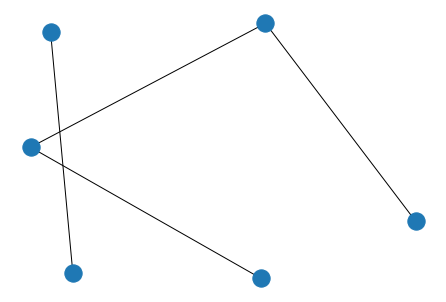

In [338]:
import os

# Select distortion [LOW, MED, HIGH]
distortion = 'LOW'

# Select letter [A, E, F, H, I, K, L, M, N, T, V, W, X, Y, Z]
letter = 'K'

# Select id [0-149]
id=100

# Read the graph and draw it using networkx tools
G = read_letters(os.path.join('Letter', distortion, letter+'P1_'+ str(id).zfill(4) +'.gxl'))
nx.draw(G, pos=dict(G.nodes(data='position')))

### Define dataset


#### Dataset Division

The dataset is divided by means of CXL files in *train*, *validation* and *test* with the correspondance filename and class:


```
<GraphCollection>
  <fingerprints base="/scratch/mneuhaus/progs/letter-database/automatic/0.1" classmodel="henry5" count="750">
    <print file="AP1_0100.gxl" class="A"/>
    ...
    <print file="ZP1_0149.gxl" class="Z"/>
  </fingerprints>
</GraphCollection>
```

In [339]:
def getFileList(file_path):
  """Parse CXL file and returns the corresponding file list and class
  """
  
  elements, classes = [], []
  tree = ET.parse(file_path)
  root = tree.getroot()
  
  for child in root:
    for sec_child in child:
      if sec_child.tag == 'print':
        elements += [sec_child.attrib['file']]
        classes += sec_child.attrib['class']
        
  return elements, classes

#### Define Dataset Class
Pytorch provides an abstract class representig a dataset, ```torch.utils.data.Dataset```. We need to override two methods:

*   ```__len__``` so that ```len(dataset)``` returns the size of the dataset.
*   ```__getitem__``` to support the indexing such that ```dataset[i]``` can be used to get i-th sample


In [340]:
import torch.utils.data as data
from torch.utils.data import DataLoader

class Letters(data.Dataset):
  def __init__(self, root_path, file_list):
    self.root = root_path
    self.file_list = file_list
    
    # List of files and corresponding labels
    self.graphs, self.labels = getFileList(os.path.join(self.root, self.file_list))
    
    # Labels to numeric value
    self.unique_labels = np.unique(self.labels)
    self.num_classes = len(self.unique_labels)
    
    self.labels = [np.where(target == self.unique_labels)[0][0] 
                   for target in self.labels]
    
    
  def __getitem__(self, index):
    # Read the graph and label
    g = read_letters(os.path.join(self.root, self.graphs[index]))
    target = self.labels[index]
    
    nodelist, nodes = map(list, zip(*g.nodes(data='position')))

    nodes = np.array(nodes)
    edges = np.array(nx.adjacency_matrix(g, nodelist=nodelist).todense())
    
    return nodes, edges, target
  
  def label2class(self, label):
    # Converts the numeric label to the corresponding string
    return self.unique_labels[label]
  
  def __len__(self):
    # Subset length
    return len(self.labels)

  
# Define the corresponding subsets for train, validation and test.
trainset = Letters(os.path.join('Letter', distortion), 'train.cxl')
validset = Letters(os.path.join('Letter', distortion), 'validation.cxl')
testset = Letters(os.path.join('Letter', distortion), 'test.cxl')

print(len(trainset.labels))
print((trainset.labels[100]))
print(len(trainset.graphs))
print((trainset.graphs[0]))
print((trainset.unique_labels))
print((trainset.num_classes))

print(len(validset.labels))
print(len(testset.labels))

print(trainset.__getitem__(100)[0])
print(trainset.__getitem__(100)[1])
print(trainset.__getitem__(100)[2])

750
2
750
AP1_0000.gxl
['A' 'E' 'F' 'H' 'I' 'K' 'L' 'M' 'N' 'T' 'V' 'W' 'X' 'Y' 'Z']
15
750
750
[[0.626163 2.85025 ]
 [0.617416 0.715336]
 [0.572522 1.65465 ]
 [1.65172  1.66186 ]
 [2.1      2.78    ]
 [0.706782 0.799407]]
[[0. 1. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]]
2


### Prepare DataLoader

```torch.utils.data.DataLoader``` is an iterator which provides:


*   Data batching
*   Shuffling the data
*   Parallel data loading

In our specific case, we need to deal with graphs of many sizes.

In [341]:
from scipy.linalg import block_diag

def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    batched_nodes, batched_edges, labels = map(list, zip(*samples))
    
    graph_shape = list(map(lambda g: g.shape[0], batched_nodes))
    
    # Return Node features, adjacency matrix, graph size and labels
    return  torch.tensor(np.concatenate(batched_nodes, axis=0)).float(), \
            torch.tensor(block_diag(*batched_edges)).float(), \
            torch.tensor(graph_shape), \
            torch.tensor(labels)
        
# Define the three dataloaders. Train data will be shuffled at each epoch   
train_loader = DataLoader(trainset, batch_size=32, shuffle=True,
                         collate_fn=collate)
valid_loader = DataLoader(validset, batch_size=32, collate_fn=collate)
test_loader = DataLoader(testset, batch_size=32, collate_fn=collate)

## Define Model

Firstly, we have to define a Graph Convolution layer

### Graph Convolution

![Graph Convolution](http://romain.raveaux.free.fr/document/simplgcnn.PNG)
![Graph Convolution](https://user-images.githubusercontent.com/7347296/34198790-eb5bec96-e56b-11e7-90d5-157800e042de.png)



In [342]:
import torch
import torch.nn as nn

class GraphConvolution(nn.Module):
  """
    Simple graph convolution
  """
  
  def __init__(self, in_features, out_features, bias=True, batchnorm=False):
    super(GraphConvolution, self).__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.bias = bias
    self.fc = nn.Linear(self.in_features, self.out_features, bias=self.bias)
    
    self.batchnorm = batchnorm
    
      
  #H are node features for all graphs batch
  #A are adjacency matrix for all graphs batch
  # GraphConv = AHW
  def forward(self, H, A):

    output = torch.matmul(A, H)
    #FC is just a linear function input multiplied by the paramaters W
    output = self.fc(output)
    
    return output

## Define Model

In [343]:
import torch.nn.functional as F
# A Simple model with 2 graph conv layers and one linear layer for classification
# activation function are ReLus
class Net(nn.Module):
  def __init__(self, in_dim, hidden_dim, n_classes):
    super(Net, self).__init__()
    self.layers = nn.ModuleList([
        GraphConvolution(in_dim, hidden_dim),
        GraphConvolution(hidden_dim, hidden_dim)])
    self.classify = nn.Linear(hidden_dim, n_classes)
    
  def forward(self, h, adj, gs):
    # Add self connections to the adjacency matrix
    id = torch.eye(h.shape[0])
    m_adj=id+adj  
    for conv in self.layers:
      h = F.relu(conv(h, m_adj))
    
    
    # Average the nodes
    #here we make the mean of the all the node embedding by graph
    #we do that to obtain a single vector by graph
    #we do that for classification purpose
    count=0
    hg=torch.zeros((gs.shape[0],h.shape[1]))
    for i in range(0,gs.shape[0]):
        hg[i]=h[count:count+gs[i]].mean(axis=0)
        count=count+gs[i]
    
    return self.classify(hg)

# What is the output of the network ?

## Training setup

In [344]:
import torch.optim as optim

model = Net(2, 256, trainset.num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
model.train()


epoch_losses = []
for epoch in range(20):
  epoch_loss = 0
  for iter, (bn, be, gs, label) in enumerate(train_loader):
    prediction = model(bn, be, gs)
    loss = loss_func(prediction, label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch_loss += loss.detach().item()
  epoch_loss /= (iter + 1)
  print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
  epoch_losses.append(epoch_loss)

Epoch 0, loss 3.7354
Epoch 1, loss 2.7147
Epoch 2, loss 2.7105
Epoch 3, loss 2.7093
Epoch 4, loss 2.7097
Epoch 5, loss 2.7100
Epoch 6, loss 2.7098
Epoch 7, loss 2.7160
Epoch 8, loss 2.5985
Epoch 9, loss 2.3694
Epoch 10, loss 2.1641
Epoch 11, loss 2.1023
Epoch 12, loss 1.9997
Epoch 13, loss 1.8764
Epoch 14, loss 1.7999
Epoch 15, loss 1.6858
Epoch 16, loss 1.5774
Epoch 17, loss 1.5058
Epoch 18, loss 1.4239
Epoch 19, loss 1.3211


## Evaluation

In [345]:
def accuracy(output, target):
  """Accuacy given a logit vector output and a target class
  """
  _, pred = output.topk(1)
  pred = pred.squeeze()
  correct = pred == target
  correct = correct.float()
  return correct.sum() * 100.0 / correct.shape[0]


model.eval()
acc = 0
with torch.no_grad():
  for iter, (bn, be, gs, label) in enumerate(test_loader):
    prediction = model(bn, be, gs)
    acc += accuracy(prediction, label) * label.shape[0]
acc = acc/len(testset)

print('Test accuracy {:.4f}'.format(acc))

Test accuracy 65.7333


## Plot results

D:\software\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


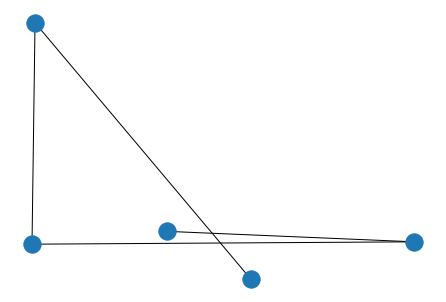

Label 6 L; Prediction 6 L


D:\software\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


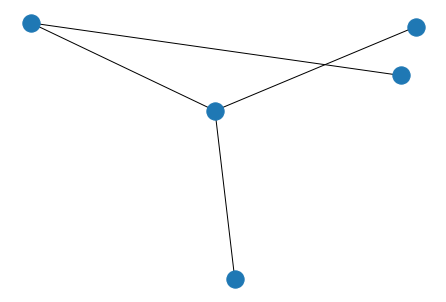

Label 13 Y; Prediction 13 Y


D:\software\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


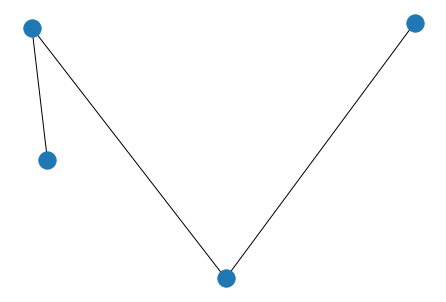

Label 10 V; Prediction 9 T


D:\software\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


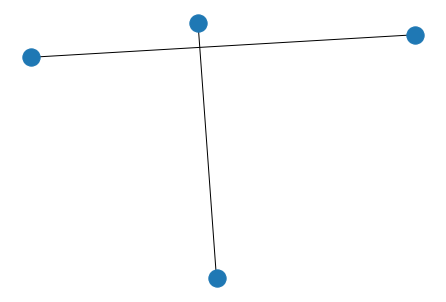

Label 9 T; Prediction 9 T


D:\software\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


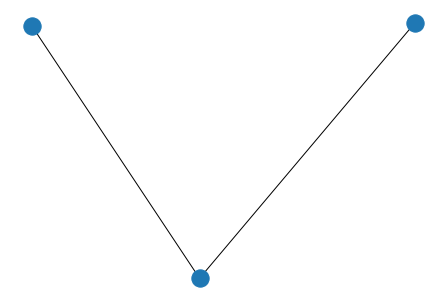

Label 10 V; Prediction 10 V


D:\software\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


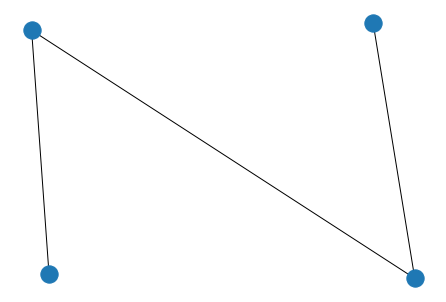

Label 8 N; Prediction 8 N


D:\software\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


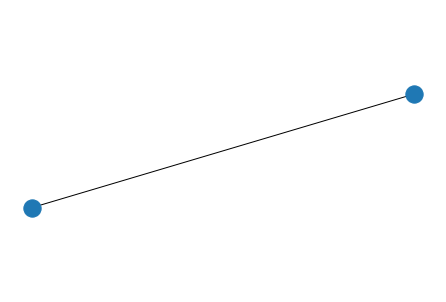

Label 6 L; Prediction 6 L


D:\software\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


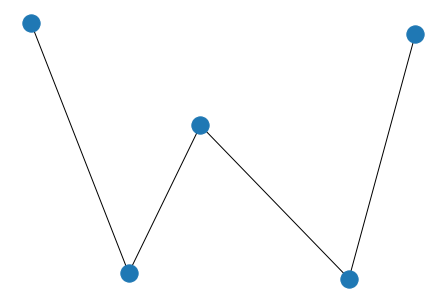

Label 11 W; Prediction 11 W


D:\software\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


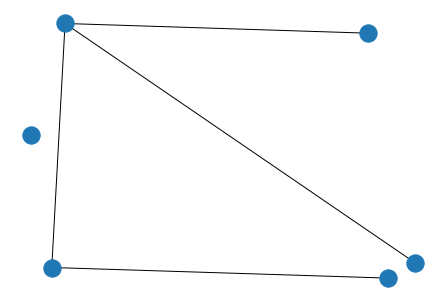

Label 1 E; Prediction 14 Z


D:\software\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


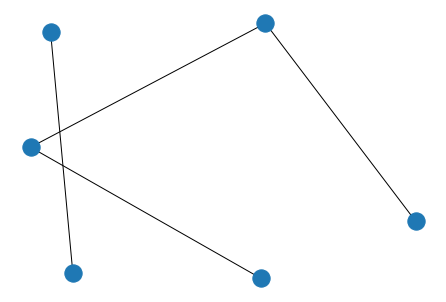

Label 5 K; Prediction 3 H


In [346]:
from random import randrange
import matplotlib.pyplot as plt
for i in range(10):
  index = randrange(len(testset))
  nod, edg, label = testset[index]
  nodes, edges, gs = torch.from_numpy(nod).float(), torch.from_numpy(edg).float(), torch.tensor(nod.shape[0]).unsqueeze(0)
  pred = model(nodes, edges, gs)
  _, pred = pred.topk(1)
  
  G = nx.from_numpy_matrix(edg)
  plt.figure(i)
  position = {k: v for k, v in enumerate(nod)}
  nx.draw(G, pos=position, arrows=False)
  plt.show()
  print('Label {} {}; Prediction {} {}'.format(label, testset.label2class(label), pred.item(), testset.label2class(pred.item())))

# To do by the student

## 1. Understand the class GraphConvolution
## 2. Understand the class  Net

# 3. Improved GCN Model
## Code the following model (The tips at the end of this section are importants)
![Graph Convolution](http://romain.raveaux.free.fr/document/gcnnimproved.PNG)
## Tips

### a°) In the class named Net, the conv layer will take a list as an input :  [identity, adjacency]
1. conv(h, [I,adj])

### b°) In the GraphConv class, the number of parameters should be twice bigger :  W = [2* self.inputfeatures, nb filters]
res1= I.H
res2 =A.H
res= res1 cat res2. Where cat can be understood as a column wise stack of res2 onto res1.
output = res.W

### c°) First, try the model without the normalization (|$\mathcal{N}$(v)|) it should work really fine.
### d°) Then introduce the normalization. res2 =$D^{-1}$A.H. And D is the degree matrix. The degree matrix can be computed like that : $D=torch.diag(torch.diag(A\mathbf{1}))$. $\mathbf{1}$ is matrix full of ones.

## ImprovedGCNModel

In [347]:
import torch
import torch.nn as nn

class GraphConvolution(nn.Module):
  """
    Simple graph convolution
  """
  
  def __init__(self, in_features, out_features, bias=True, batchnorm=False):
    super(GraphConvolution, self).__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.bias = bias
    self.fc = nn.Linear(2*self.in_features, self.out_features, bias=self.bias)
    
    self.batchnorm = batchnorm
    
      
  #H are node features for all graphs batch
  #W are adjacency matrix for all graphs batch

  def forward(self, H, A):
    
    id=A[0]
    adj=A[1]
    
    #degree matrix
    D = torch.diag(torch.matmul(adj+id,torch.ones(adj.shape[0])))
    #res1= I.H 
    res1 = torch.matmul(id, H)
    # res2 = 𝐷−1 A.H
    res2 = torch.matmul(torch.matmul(torch.inverse(D),adj), H)
    
    # res= res1 cat res2. Where cat can be understood as a column wise stack of res2 onto res1.
    res = torch.cat((res2, res1), 1)

    #FC is just a linear function input multiplied by the paramaters W
    output = self.fc(res)
    
    return output

In [348]:
import torch.nn.functional as F
# A Simple model with 2 graph conv layers and one linear layer for classification
# activation function are ReLus
class Net(nn.Module):
  def __init__(self, in_dim, hidden_dim, n_classes):
    super(Net, self).__init__()
    self.layers = nn.ModuleList([
        GraphConvolution(in_dim, hidden_dim),
        GraphConvolution(hidden_dim, hidden_dim)])
    self.classify = nn.Linear(hidden_dim, n_classes)
    
  def forward(self, h, adj, gs):
    # Add self connections to the adjacency matrix
    id = torch.eye(h.shape[0])
    # m_adj=id+adj  
    # the conv layer will take a list as an input
    for conv in self.layers:
      h = F.relu(conv(h, [id,adj]))
    
    
    # Average the nodes
    #here we make the mean of the all the node embedding by graph
    #we do that to obtain a single vector by graph
    #we do that for classification purpose
    count=0
    hg=torch.zeros((gs.shape[0],h.shape[1]))
    for i in range(0,gs.shape[0]):
        hg[i]=h[count:count+gs[i]].mean(axis=0)
        count=count+gs[i]
    
    return self.classify(hg)

## Training

In [349]:
import torch.optim as optim

model = Net(2, 256, trainset.num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
model.train()


epoch_losses = []
for epoch in range(20):
  epoch_loss = 0
  for iter, (bn, be, gs, label) in enumerate(train_loader):
    prediction = model(bn, be, gs)
    loss = loss_func(prediction, label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch_loss += loss.detach().item()
  epoch_loss /= (iter + 1)
  print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
  epoch_losses.append(epoch_loss)

Epoch 0, loss 2.6432
Epoch 1, loss 1.4119
Epoch 2, loss 0.7201
Epoch 3, loss 0.5273
Epoch 4, loss 0.4178
Epoch 5, loss 0.3435
Epoch 6, loss 0.3081
Epoch 7, loss 0.2710
Epoch 8, loss 0.2154
Epoch 9, loss 0.2056
Epoch 10, loss 0.1628
Epoch 11, loss 0.1598
Epoch 12, loss 0.1722
Epoch 13, loss 0.1710
Epoch 14, loss 0.1306
Epoch 15, loss 0.1437
Epoch 16, loss 0.1253
Epoch 17, loss 0.1216
Epoch 18, loss 0.0933
Epoch 19, loss 0.0761


# 4. Test the new model

## Evaluation

In [350]:
def accuracy(output, target):
  """Accuacy given a logit vector output and a target class
  """
  _, pred = output.topk(1)
  pred = pred.squeeze()
  correct = pred == target
  correct = correct.float()
  return correct.sum() * 100.0 / correct.shape[0]


model.eval()
acc = 0
with torch.no_grad():
  for iter, (bn, be, gs, label) in enumerate(test_loader):
    prediction = model(bn, be, gs)
    acc += accuracy(prediction, label) * label.shape[0]
acc = acc/len(testset)

print('Test accuracy {:.4f}'.format(acc))

Test accuracy 96.0000


## Plot results

D:\software\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


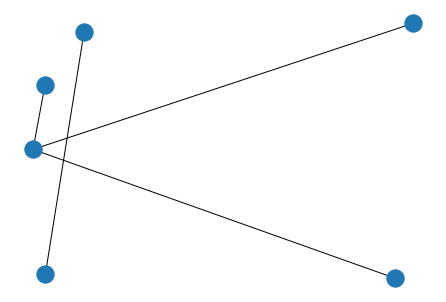

Label 5 K; Prediction 5 K


D:\software\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


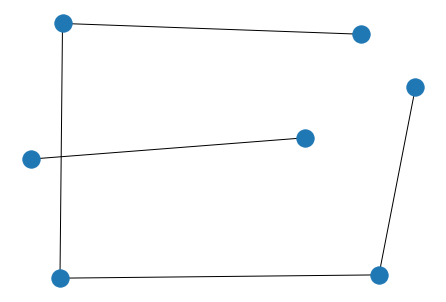

Label 1 E; Prediction 1 E


D:\software\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


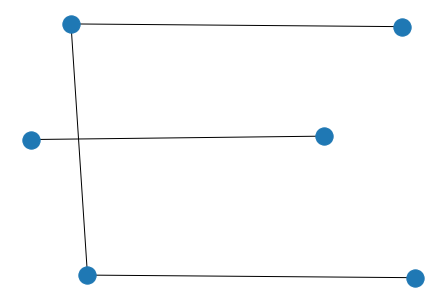

Label 1 E; Prediction 1 E


D:\software\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


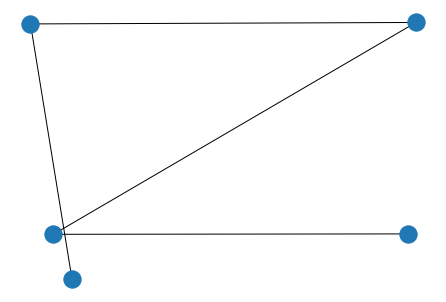

Label 14 Z; Prediction 14 Z


D:\software\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


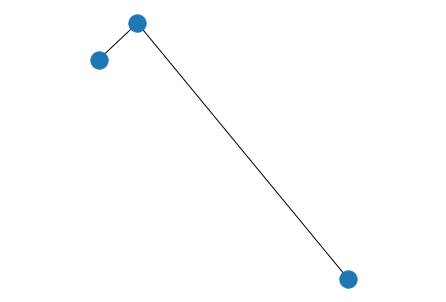

Label 4 I; Prediction 4 I


D:\software\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


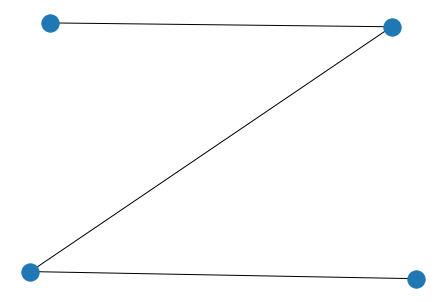

Label 14 Z; Prediction 14 Z


D:\software\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


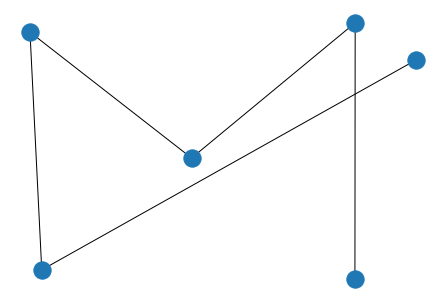

Label 7 M; Prediction 7 M


D:\software\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


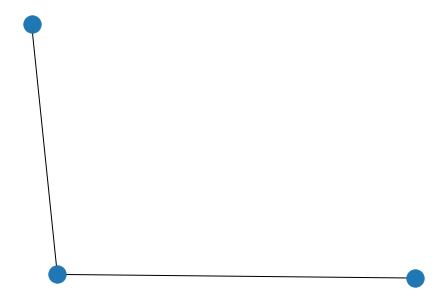

Label 6 L; Prediction 6 L


D:\software\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


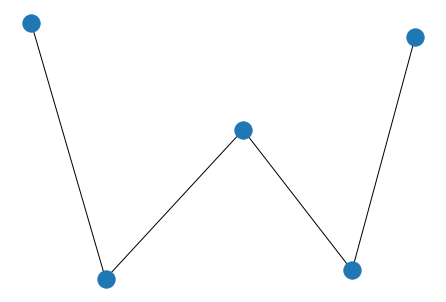

Label 11 W; Prediction 11 W


D:\software\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


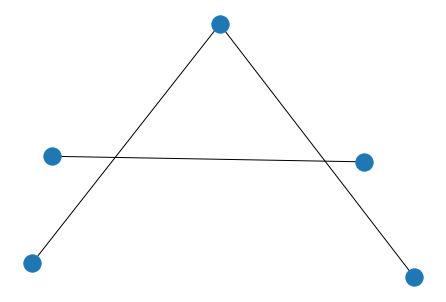

Label 0 A; Prediction 0 A


In [351]:
from random import randrange
import matplotlib.pyplot as plt
for i in range(10):
  index = randrange(len(testset))
  nod, edg, label = testset[index]
  nodes, edges, gs = torch.from_numpy(nod).float(), torch.from_numpy(edg).float(), torch.tensor(nod.shape[0]).unsqueeze(0)
  pred = model(nodes, edges, gs)
  _, pred = pred.topk(1)
  
  G = nx.from_numpy_matrix(edg)
  plt.figure(i)
  position = {k: v for k, v in enumerate(nod)}
  nx.draw(G, pos=position, arrows=False)
  plt.show()
  print('Label {} {}; Prediction {} {}'.format(label, testset.label2class(label), pred.item(), testset.label2class(pred.item())))

# 5. Conclude
Why is the new model better than the first one ?

In [352]:
Nous pouvons observer que le nouveau modèle a une amélioration significative par rapport au modèle précédent. Nous pensons que la principale raison de l'amélioration des performances est l'augmentation du nombre de paramètres dans la couche de convolution du modèle

SyntaxError: invalid syntax (<ipython-input-352-4077ca4d38bf>, line 1)